In [1]:
from BioLink.biolink_client import BioLinkWrapper
import pandas as pd
from pprint import pprint
from collections import defaultdict
from mygene import MyGeneInfo

In [2]:
# instantiate helpers
blw = BioLinkWrapper()
mg = MyGeneInfo()

In [3]:
def map_id(in_id):
    return blw.get_obj(obj_id=in_id)['id']

# Workflow 2 
## Progeria implementation

## Module declaration

In [4]:
worklow_modules = [
    ('Mod1A', 'Mod1A Functional Similarity'),
    ('Mod1B', 'Mod1B Phenotype Similarity'),
    ('Mod1C', 'Mod1C Coexpression'),
    ('Mod1D', 'Mod1D Gene Chemical Interaction'),
    ('Mod1E', 'Mod1E Gene Interaction'),
    ('Mod3', 'Mod3 Candidate Merging')
]

## Workflow input

In [5]:
from Modules.Mod0_lookups import LookUp

# workflow input is a disease identifier
input_disease = ('MONDO:0008310') # Progeria
lu = LookUp()
input_object = lu.input_object_lookup(input_curie=input_disease)
input_object

{'id': 'MONDO:0008310',
 'label': 'progeria',
 'description': 'Hutchinson-Gilford progeria syndrome is a rare, fatal, autosomal dominant and premature aging disease, beginning in childhood and characterized by growth reduction, failure to thrive, a typical facial appearance (prominent forehead, protuberant eyes, thin nose with a beaked tip, thin lips, micrognathia and protruding ears) and distinct dermatologic features (generalized alopecia, aged-looking skin, sclerotic and dimpled skin over the abdomen and extremities, prominent cutaneous vasculature, dyspigmentation, nail hypoplasia and loss of subcutaneous fat).'}

# Mod0 Input Lookup
## Get Disease associated genes from BioLink API api.monarchinitative.org

In [6]:
# Module specification
mod0_config = {
    'id': input_object['id'],
    'data_type': 'disease',
    'input_type': {
        'complexity': 'single',
        'id_type': ['MONDO', 'DO', 'OMIM'],   
    },
    'output_type': {
        'complexity': 'set',
        'id_type': 'HGNC'
    },
    'taxon': 'human',
    'limit': None,
    'source': 'Monarch Biolink',
    'predicate': 'blm:gene associated with condition'
}

In [7]:
# get genes associated with disease from Biolink
disease_associated_genes = lu.disease_geneset_lookup(disease2genes_object=mod0_config)
# create list of gene curies for downstream module input
input_curie_set = disease_associated_genes['hit_id'].tolist()
# show the 
disease_associated_genes

,input_id,input_label,hit_id,hit_label,ncbi,sources
0,MONDO:0008310,progeria,HGNC:12877,ZMPSTE24,NCBIGene:10269,"ctd, orphane"
1,MONDO:0008310,progeria,HGNC:17397,BANF1,NCBIGene:8815,"omim, ctd, orphane, clinvar"
2,MONDO:0008310,progeria,HGNC:25356,SPRTN,NCBIGene:83932,ctd
3,MONDO:0008310,progeria,HGNC:494,ANK3,NCBIGene:288,ctd
4,MONDO:0008310,progeria,HGNC:6636,LMNA,NCBIGene:4000,"ctd, omim, orphane, clinvar, corie"
5,MONDO:0008310,progeria,HGNC:9721,PYCR1,NCBIGene:5831,ctd


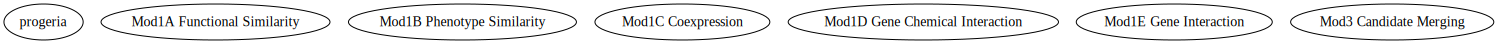

In [8]:
from GraphVisuals.graphviz_wrapper import PathGraph

# instantiate workflow graph
path_graph = PathGraph(input_curie=input_object['id'], input_label=input_object['label'])
path_graph.load_nodes(node_list=worklow_modules)
path_graph.path_graph

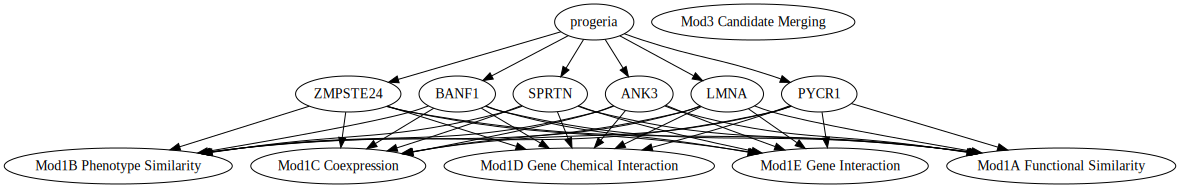

In [9]:
# graph fanconi genes 2 mod1
path_graph.load_nodes(list(zip(disease_associated_genes['hit_id'], disease_associated_genes['hit_label'])))
path_graph.module_outputs(output_gene_set=input_curie_set, module_id=path_graph.conv_pref(input_disease))
for module in worklow_modules[:-1]:
    path_graph.module_inputs(input_gene_set=input_curie_set, module_id=module[0])
path_graph.path_graph

In [10]:
# start a list of final candidates from each module
mod1_candidates = list()

# Mod1A Functional Similarity
## Find similar genes based on GO functional annotations using OntoBio Jaccard similarity

In [11]:
from Modules.Mod1A_functional_sim import FunctionalSimilarity

# Module specification
mod1a_config = {
    'input': input_curie_set,
    'input_type': {
        'complexity': 'set',
        'id_type': 'HGNC', 
        'data_type': 'gene',
    },
    'output_type': {
        'complexity': 'set',
        'id_type': 'HGNC',
        'data_type': 'gene',
    },
    'parameters': {
        'taxon': 'human',
        'threshold': 0.55,
    },
    
    'source': 'Monarch Biolink',
    'predicate': ['blm:macromolecular machine to biological process association', 
                  'macromolecular machine to molecular activity association']
} 


func_sim = FunctionalSimilarity()
func_sim.load_gene_set(mod1a_config['input']) 
func_sim.load_associations() 
Mod1A_results = pd.DataFrame(func_sim.compute_similarity(lower_bound=mod1a_config['parameters']['threshold']))  
Mod1A_results = Mod1A_results[~Mod1A_results['sim_hit_name'].isin(disease_associated_genes['hit_label'])]
Mod1A_results

/Users/tputman/.virtualenvs/modules/lib/python3.6/site-packages/cachier/mongo_core.py:24: UserWarning: Cachier warning: pymongo was not found. MongoDB cores will not work.
  "Cachier warning: pymongo was not found. MongoDB cores will not work.")


,input_curie,sim_hit_curie,sim_hit_name,sim_score
2,HGNC:25356,UniProtKB:O14519,CDK2AP1,0.552239
3,HGNC:25356,UniProtKB:Q6NZ36,FAAP20,0.588235
4,HGNC:25356,UniProtKB:Q6ZNA4,RNF111,0.567901
5,HGNC:25356,UniProtKB:Q96MG7,NSMCE3,0.572414
6,HGNC:25356,UniProtKB:Q96PM5,RCHY1,0.587879
8,HGNC:25356,UniProtKB:Q9NVI1,FANCI,0.666667
9,HGNC:25356,UniProtKB:Q9UBZ9,REV1,0.561983
13,HGNC:9721,UniProtKB:Q96C36,PYCR2,0.587719


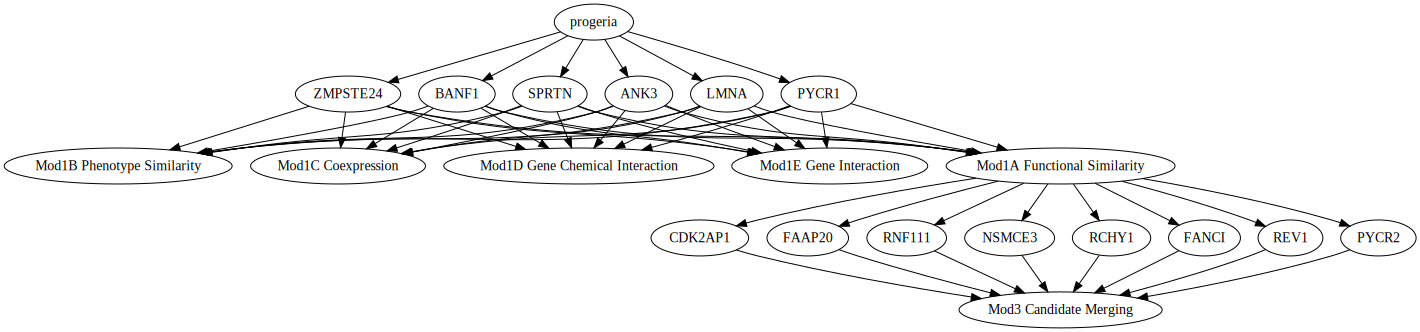

In [12]:
# graph mod1A genes 2 Mod3
for index, row in Mod1A_results.iterrows():
    mod1_candidates.append({
        'input_curie': row[0],
        'output_curie': row[1],
        'output_name': row[2],
        'module': 'Mod1A'
    }) 
path_graph.load_nodes(list(zip(Mod1A_results['sim_hit_curie'], Mod1A_results['sim_hit_name'])))
path_graph.module_inputs(input_gene_set=Mod1A_results['sim_hit_curie'].tolist(), module_id='Mod3')
path_graph.module_outputs(output_gene_set=Mod1A_results['sim_hit_curie'].tolist(), module_id='Mod1A')
path_graph.path_graph

# Mod1B Phenotype Similarity
## Find similar genes based on OwlSim calculated Phenotype Similarity

In [13]:
from Modules.Mod1B_phenotype_similarity import PhenotypeSimilarity

# Module specification
mod1b_config = {
    'input': input_curie_set,
    'input_type': {
        'complexity': 'set',
        'id_type': 'HGNC',
        'data_type': 'gene',
    },
    'output_type': {
        'complexity': 'set',
        'id_type': 'HGNC',
        'data_type': 'gene',
    },
    'parameters': {
        'taxon': 'human',
        'threshold': 100,
    },
    'source': 'Monarch Biolink',
    'predicate': ['blm:has phenotype']
}

pheno_sim = PhenotypeSimilarity()
pheno_sim.load_gene_set(mod1b_config['input'])
pheno_sim.load_associations()
Mod1B_results = pheno_sim.similarity_search()

'label' <SimSearch.simsearch_client.SimScoreMatch object at 0x13a534828>
'label' <SimSearch.simsearch_client.SimScoreMatch object at 0x13a534c88>
'label' <SimSearch.simsearch_client.SimScoreMatch object at 0x13a534cc0>
'label' <SimSearch.simsearch_client.SimScoreMatch object at 0x13a52d080>
'label' <SimSearch.simsearch_client.SimScoreMatch object at 0x13a52d0b8>
'label' <SimSearch.simsearch_client.SimScoreMatch object at 0x13a52d470>
'label' <SimSearch.simsearch_client.SimScoreMatch object at 0x13a52d4a8>
'label' <SimSearch.simsearch_client.SimScoreMatch object at 0x13a52d588>
'label' <SimSearch.simsearch_client.SimScoreMatch object at 0x13a52d5f8>
'label' <SimSearch.simsearch_client.SimScoreMatch object at 0x13a52d668>
'label' <SimSearch.simsearch_client.SimScoreMatch object at 0x13a52d780>
'label' <SimSearch.simsearch_client.SimScoreMatch object at 0x13a52d860>
'label' <SimSearch.simsearch_client.SimScoreMatch object at 0x13a52dbe0>
'label' <SimSearch.simsearch_client.SimScoreMatch o

In [14]:
Mod1B_results = Mod1B_results[~Mod1B_results['label_x'].isin(disease_associated_genes['hit_label'])]
Mod1B_results = Mod1B_results[~Mod1B_results['id'].str.contains('MONDO')]
Mod1B_results = Mod1B_results[Mod1B_results['summed_score'] > 100]
Mod1B_results['hit_id'] = Mod1B_results['id'].apply(map_id)
Mod1B_results

,input_id_x,id,label_x,summed_score,hit_id
12,HGNC:12877,OMIM:600275,NOTCH2,143.0,HGNC:7882
16,HGNC:12877,OMIM:612373,SLC29A3,135.0,HGNC:23096
18,HGNC:12877,OMIM:173325,JUP,133.0,HGNC:6207
20,HGNC:12877,OMIM:120180,COL3A1,133.0,HGNC:2201
22,HGNC:12877,OMIM:615291,B3GALT6,132.0,HGNC:17978
42,HGNC:12877,OMIM:611716,ATP6V0A2,131.0,HGNC:18481
52,HGNC:12877,OMIM:601105,CTSK,141.0,HGNC:2536
67,HGNC:12877,OMIM:300017,FLNA,130.0,HGNC:3754
71,HGNC:12877,HGNC:38881,MIR3606,130.0,HGNC:38881
75,HGNC:12877,OMIM:605497,CRTAP,132.0,HGNC:2379


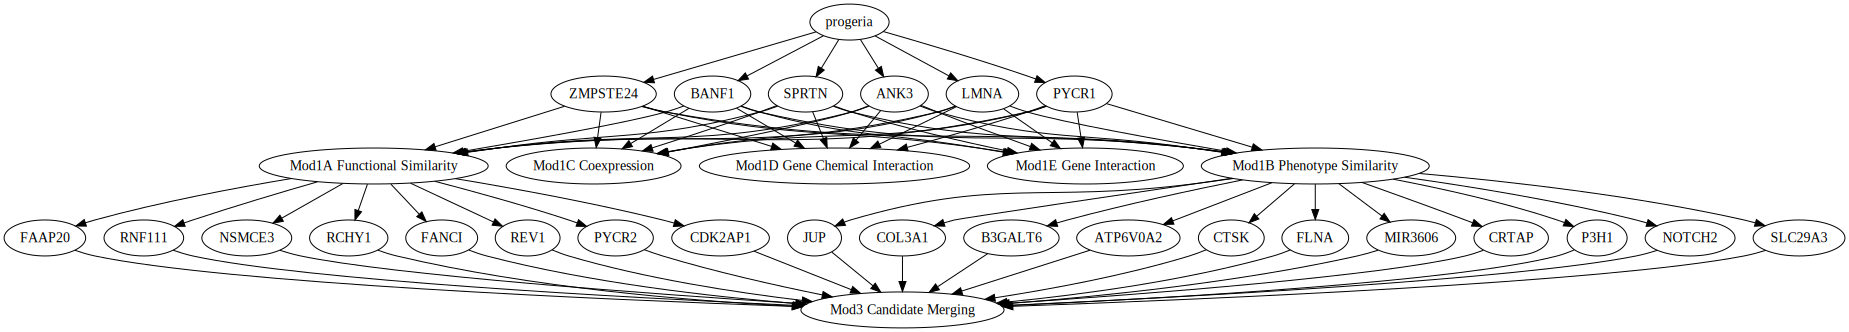

In [15]:
# graph mod1B genes 2 Mod3
for index, row in Mod1B_results.iterrows():
    mod1_candidates.append({
        'input_curie': row[0],
        'output_curie': row[-1],
        'output_name': row[2],
        'module': 'Mod1B'
    }) 
path_graph.load_nodes(list(zip(Mod1B_results['hit_id'], Mod1B_results['label_x'])))
path_graph.module_outputs(output_gene_set=Mod1B_results['hit_id'].tolist(), module_id='Mod1B')
path_graph.module_inputs(input_gene_set=Mod1B_results['hit_id'].tolist(), module_id='Mod3')
path_graph.path_graph

# Mod1C Coexpression

In [16]:
# TODO

# Mod1D Chemical Gene Interactions

In [17]:
# Needs work, way too many hits 

In [18]:
# increases expression instance
# from Modules.Mod1D_Chemical_Gene import ChemicalGeneInteractions

In [19]:
# use only fa core genes 
# fa_core_genes = ['FANCA','FANCB','FANCC','FANCE','FANCF','FANCG','FANCL','FANCM','FANCD2','FANCI','UBE2T','SLX4']
# fa_genes_df[fa_genes_df['hit_label'].str.contains('|'.join(fa_core_genes))]

In [20]:
# gci = ChemicalGeneInteractions()
# gci.load_gene_set(gene_set=fa_genes_df[fa_genes_df['hit_label'].str.contains('|'.join(fa_core_genes))])
# only return chemicals that decrease expression of fa genes
# gci.get_chemicals(action='decreases^expression')
# gci.load_gene_hits(action='decreases^expression', rows=2)

# Mod1E Gene Interactions

In [21]:
from Modules.Mod1E_interactions import GeneInteractions

# Module specification
mod1e_config = {
    'input': input_curie_set,
    'input_type': {
        'complexity': 'set',
        'id_type': 'HGNC',
        'data_type': 'gene',
    },
    'output_type': {
        'complexity': 'set',
        'id_type': 'HGNC',
        'data_type': 'gene',
    },
    'parameters': {
        'taxon': 'human',
        'threshold': None,
    },
    'source': 'Monarch Biolink',
    'predicate': ['blm:interacts with']
}

gene_inter = GeneInteractions()
gene_inter.load_gene_set(gene_set=mod1e_config['input'])
gene_inter.get_interactions()
Mod1E_results = pd.DataFrame(gene_inter.interactions)

In [22]:
Mod1E_results = Mod1E_results[~Mod1E_results['hit_label'].isin(disease_associated_genes['hit_label'])]

In [23]:
grouped_Mod1E_results = Mod1E_results.groupby(['hit_id','hit_label'])['input_id'].apply(', '.join).reset_index()

In [24]:
trimmed_Mod1E_results = list()
for index, row in grouped_Mod1E_results.iterrows():
    if len(row[-1].split(',')) > 1:
        trimmed_Mod1E_results.append(row)
Mod1E_results = pd.DataFrame(trimmed_Mod1E_results, columns=['hit_id', 'hit_label', 'input_id'])
Mod1E_results   

,hit_id,hit_label,input_id
0,HGNC:1006,BCL7C,"HGNC:17397, HGNC:25356"
1,HGNC:10061,RNF2,"HGNC:494, HGNC:9721"
17,HGNC:1066,BMI1,"HGNC:17397, HGNC:9721"
30,HGNC:11010,SLC2A5,"HGNC:12877, HGNC:6636"
38,HGNC:11177,SOAT1,"HGNC:17397, HGNC:9721"
48,HGNC:11440,STX5,"HGNC:494, HGNC:6636"
54,HGNC:11875,TMPO,"HGNC:17397, HGNC:25356"
60,HGNC:12420,TUFM,"HGNC:17397, HGNC:25356"
68,HGNC:12669,VDAC1,"HGNC:17397, HGNC:25356"
185,HGNC:21163,MDC1,"HGNC:17397, HGNC:9721"


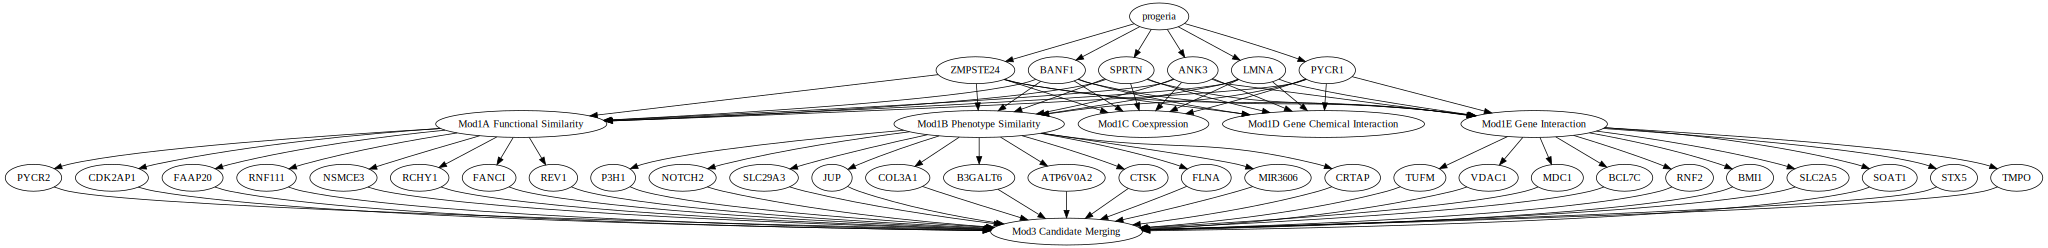

In [25]:
# graph mod1E genes 2 Mod3
for index, row in Mod1E_results.iterrows():
    mod1_candidates.append({
        'input_curie': row[-1],
        'output_curie': row[0],
        'output_name': row[1],
        'module': 'Mod1E',
    })

path_graph.load_nodes(list(zip(Mod1E_results['hit_id'], Mod1E_results['hit_label']))[:10])
path_graph.module_outputs(output_gene_set=Mod1E_results['hit_id'].tolist()[:10], module_id='Mod1E')
path_graph.module_inputs(input_gene_set=Mod1E_results['hit_id'].tolist()[:10], module_id='Mod3')
path_graph.path_graph

In [26]:
candidates_df = pd.DataFrame(mod1_candidates)

In [27]:
candidates_df

,input_curie,module,output_curie,output_name
0,HGNC:25356,Mod1A,UniProtKB:O14519,CDK2AP1
1,HGNC:25356,Mod1A,UniProtKB:Q6NZ36,FAAP20
2,HGNC:25356,Mod1A,UniProtKB:Q6ZNA4,RNF111
3,HGNC:25356,Mod1A,UniProtKB:Q96MG7,NSMCE3
4,HGNC:25356,Mod1A,UniProtKB:Q96PM5,RCHY1
5,HGNC:25356,Mod1A,UniProtKB:Q9NVI1,FANCI
6,HGNC:25356,Mod1A,UniProtKB:Q9UBZ9,REV1
7,HGNC:9721,Mod1A,UniProtKB:Q96C36,PYCR2
8,HGNC:12877,Mod1B,HGNC:7882,NOTCH2
9,HGNC:12877,Mod1B,HGNC:23096,SLC29A3


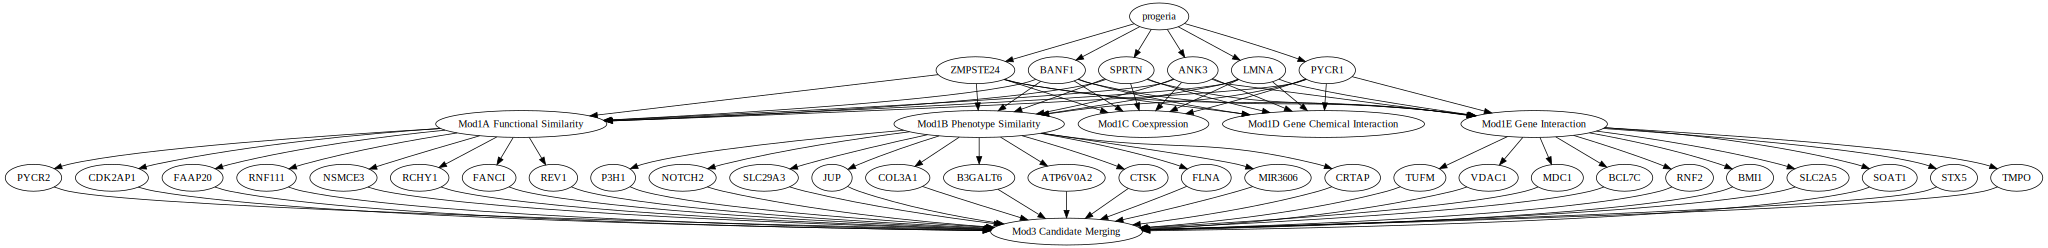

In [28]:
path_graph.path_graph

In [30]:
path_graph.path_graph.render()

'Workflow II progeria Implementation.gv.pdf'